<a href="https://colab.research.google.com/github/diaputr/machine-learning/blob/main/Modul_10_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Praktikum 1

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Moe and Larry are newly henpecked husbands, having married Shemp\'s demanding sisters. At his music studio, Shemp learns he will inherit a fortune if he marries someone himself! <br /><br />"Husbands Beware" is a remake of 1947\'s "Brideless Groom," widely considered by many to be one of the best Stooge films with Shemp. The remake contains most of the footage from that film. The new scenes, shot May 17, 1955, include the storyline of Moe and Larry marrying Shemp\'s sisters, along with their cooking of a turkey laced with turpentine! A few new scenes are tacked onto the end of the film as well(a double for Dee Green was used; if you blink, you will miss the double\'s appearance.) <br /><br />"Husbands Beware" would have made for a good film with just the plot line of marrying the sisters. Budget considerations, coupled with fewer bookings for two-reel comedies, influenced the decision to use older footage.<br /><br />Although completely new films were still being made by the

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1,   3,   1, ...,   0,   0,   0],
       [ 11,   1, 220, ...,   0,   0,   0],
       [  1,   1,   1, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Moe and Larry are newly henpecked husbands, having married Shemp\'s demanding sisters. At his music studio, Shemp learns he will inherit a fortune if he marries someone himself! <br /><br />"Husbands Beware" is a remake of 1947\'s "Brideless Groom," widely considered by many to be one of the best Stooge films with Shemp. The remake contains most of the footage from that film. The new scenes, shot May 17, 1955, include the storyline of Moe and Larry marrying Shemp\'s sisters, along with their cooking of a turkey laced with turpentine! A few new scenes are tacked onto the end of the film as well(a double for Dee Green was used; if you blink, you will miss the double\'s appearance.) <br /><br />"Husbands Beware" would have made for a good film with just the plot line of marrying the sisters. Budget considerations, coupled with fewer bookings for two-reel comedies, influenced the decision to use older footage.<br /><br />Although completely new films were still being made by t

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[0.0337405]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 59ms/step
[0.0337405]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 51s 104ms/step - loss: 0.6571 - accuracy: 0.5504 - val_loss: 0.5133 - val_accuracy: 0.7026
Epoch 2/10
391/391 [==============================] - 25s 64ms/step - loss: 0.4073 - accuracy: 0.8129 - val_loss: 0.4108 - val_accuracy: 0.7776
Epoch 3/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3416 - accuracy: 0.8504 - val_loss: 0.3421 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3201 - accuracy: 0.8608 - val_loss: 0.3297 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3135 - accuracy: 0.8639 - val_loss: 0.3267 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 24s 60ms/step - loss: 0.3058 - accuracy: 0.8679 - val_loss: 0.3227 - val_accuracy: 0.8495
Epoch 7/10
391/391 [==============================] - 23s 59ms/step - loss: 0.3029 - accuracy: 0.8690 - val_loss: 0.3172 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 28ms/step - loss: 0.3140 - accuracy: 0.8595
Test Loss: 0.3139803409576416
Test Accuracy: 0.8594800233840942


(0.0, 0.6751816883683205)

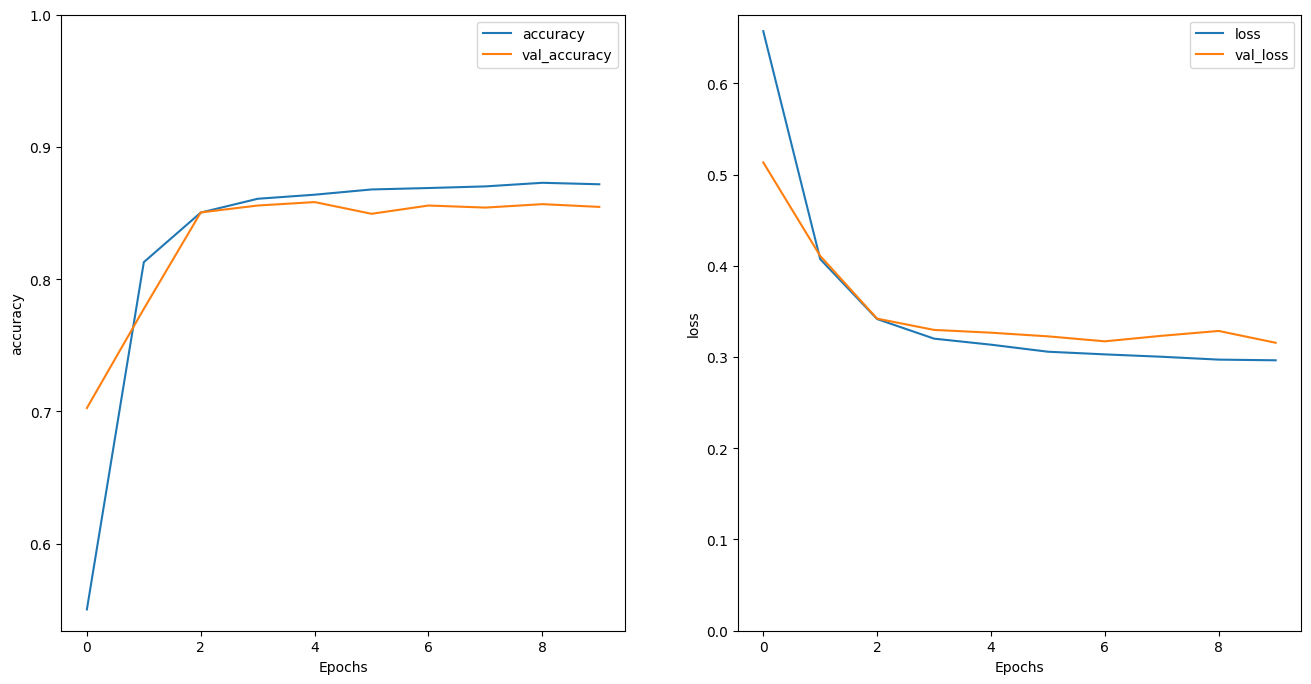

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


In [ ]:
model = tf.keras.Sequential([encoder, tf.keras.layers.Embedding(
  len(encoder.get_vocabulary()), 64, mask_zero=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 148ms/step - loss: 0.5930 - accuracy: 0.6260 - val_loss: 0.4161 - val_accuracy: 0.7979
Epoch 2/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3710 - accuracy: 0.8345 - val_loss: 0.3533 - val_accuracy: 0.8292
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3303 - accuracy: 0.8592 - val_loss: 0.3280 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 45s 116ms/step - loss: 0.3200 - accuracy: 0.8618 - val_loss: 0.3238 - val_accuracy: 0.8599
Epoch 5/10
391/391 [==============================] - 45s 114ms/step - loss: 0.3104 - accuracy: 0.8652 - val_loss: 0.3224 - val_accuracy: 0.8589
Epoch 6/10
391/391 [==============================] - 44s 112ms/step - loss: 0.3065 - accuracy: 0.8693 - val_loss: 0.3248 - val_accuracy: 0.8641
Epoch 7/10
391/391 [==============================] - 44s 111ms/step - loss: 0.3035 - accuracy: 0.8689 - val_loss: 0.3216 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 46ms/step - loss: 0.3280 - accuracy: 0.8638
Test Loss: 0.32803088426589966
Test Accuracy: 0.8637599945068359


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.6673477]]


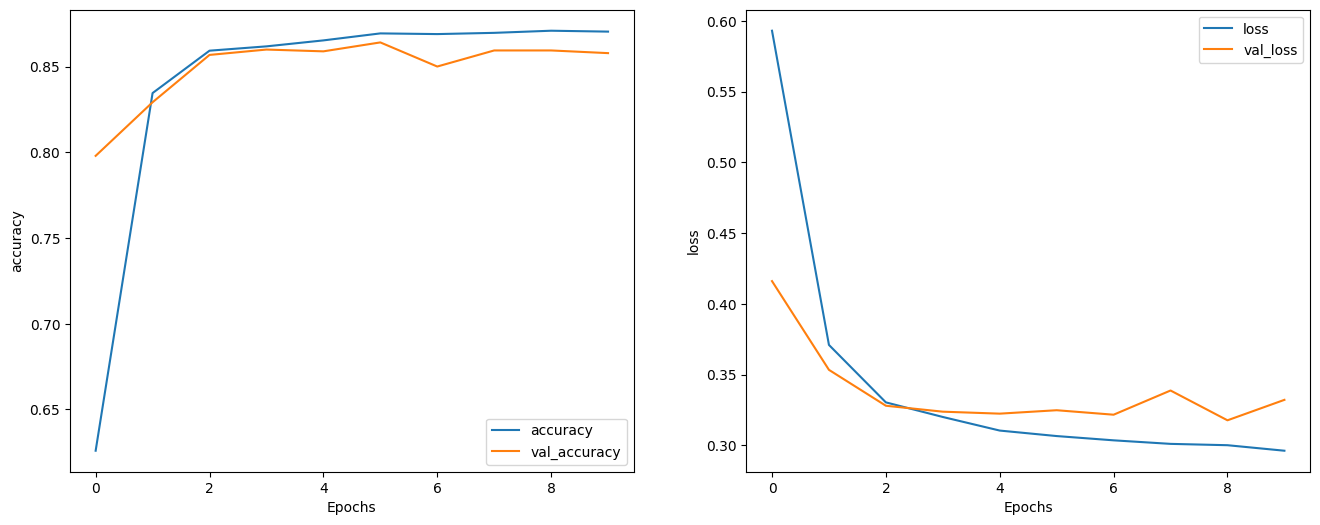

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file  = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([ 2, 56, 18, 53, 61, 17, 17, 32, 35, 49, 40, 54,  1, 19, 55, 19, 26,
       28, 34,  0, 32, 62,  7,  0, 65, 33,  8, 27, 53, 65, 60, 14,  5, 43,
       25, 25, 65, 61, 53, 45, 43, 53, 43, 54, 64,  1, 57, 59, 23, 22,  5,
       33,  6, 41, 30,  5, 18, 52,  4, 10,  9, 14, 50, 48,  2, 10, 47, 29,
       58, 42, 43, 12, 55, 27, 46, 49, 60, 29, 22, 39, 26,  9, 55, 22, 39,
       49, 26, 48, 61, 52, 45, 46, 65, 31, 35, 64, 18,  8, 52, 65])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"nce.\n\nSecond Senator:\nYou'll see your Rome embraced with fire before\nYou'll speak with Coriolanus.\n\n"

Next Char Predictions:
 b" qEnvDDSVjao\nFpFMOU[UNK]Sw,[UNK]zT-NnzuA&dLLzvnfdndoy\nrtJI&T'bQ&Em$3.Aki 3hPscd;pNgjuPIZM.pIZjMivmfgzRVyE-mz"


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1895156, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

65.990814

In [ ]:
model.compile(optimizer='adam', loss=loss)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 55ms/step - loss: 2.7350
Epoch 2/20
172/172 [==============================] - 11s 55ms/step - loss: 2.0023
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7264
Epoch 4/20
172/172 [==============================] - 11s 55ms/step - loss: 1.5626
Epoch 5/20
172/172 [==============================] - 11s 54ms/step - loss: 1.4597
Epoch 6/20
172/172 [==============================] - 11s 53ms/step - loss: 1.3900
Epoch 7/20
172/172 [==============================] - 11s 52ms/step - loss: 1.3369
Epoch 8/20
172/172 [==============================] - 11s 53ms/step - loss: 1.2914
Epoch 9/20
172/172 [==============================] - 11s 53ms/step - loss: 1.2503
Epoch 10/20
172/172 [==============================] - 11s 54ms/step - loss: 1.2105
Epoch 11/20
172/172 [==============================] - 11s 54ms/step - loss: 1.1712
Epoch 12/20
172/172 [==============================] - 11s 55ms/step - loss: 1.1305
E

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Speak sin, and a pedilate youth;
And though my eldest open my country?

Servant:
O, she is like a grim basiness, my great doers.
Nor you shake of your ancisation. Why, is your good
son?
To thee to estate his wife a breathe-business did
schooly in my living more, my lords, and my inclent time
To sacrt if an easy task it so,
And sooth, my ragies, gardened by Angels,
And yet, as 'twere, indeed, my trust to thee,
Then hail, or four o'er, by thy body
Is ragued their power into a slave, 'tis brow.
No, no, good madam, that you have of Your are,
If thou remember'st me trimm itself against a visigh, but best,
Thou madly strange love! Plantageny!
And you, mine are obenieves, or if it was;
mire-prizentle is a worthie thy people,
O'l not he do conduct the corm retter
Which thou must have forsworn my life
Of Lold Nistords both are dead. Then was thy fount
A time even never of an age.

POLIXENES:
Nay, I have stood aming
An hour should avoid my passion mercy against me.

MARCIUS:
Friar. Why, t

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nThy lords, I will not burden our country me.\nFor you, Cominius: Let us below my standing sea\nAnd marth the wind shall not be known.\n\nANGELO:\nWhat more fashions made?\nWhy did you show his king? 'dis not so, sir,\nthe very trituness of my cousin: do what I have;\nAnd now in peace that very time,\nMuch match'd in a dearer love, build\nAnd leave that men through stronger bases of their\nburst; one girl my life the lord; behold my mind\nOf triumph disgrace this day her flowery.\n\nMessenger:\nMy business is true sons of this vice chastisement,\nThat all the stands integardey' to an him, I am.\n\nKATHARINA:\nI virtuous time, whose party trespers\nDid greet my kingdom ope the measure,\nAs bring me to thy and by leave,\nAnd therefore arm us home; that so preparation\nHow thou canst wish before heavents of their creaties;\nAnd bear the sod, thy princely father, dread'st.\n\nROMEO:\nLumberly, and do set upon my life\nBut let us hence; how quicks it is it none.\n\nMENE

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
And you shall curre thee, my air, but says.

MENENIUS:
O, 'tis an accessar'? what news, is Warwick 
